In [4]:
import os
import cv2
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

svm_model = joblib.load('SVM_Detect_growth_stages.pkl')         
print('Load SVM model from SVM_Detect_growth_stages.pkl!')
# Constants
PosNum = 2*10+6
NegNum = 2*10+6
OtherNum = 2*10+6
num_test = PosNum + NegNum + OtherNum
test_seedling_list=[]
test_growth_list=[]
test_mature_list=[]
test_list=[]

test_gradient = []
test_labels = []

gamma = 0.8

def sliding_window(img, stepSize, windowSize):      #Sliding window, used to take the area during detection
  for y in range(0, img.shape[0], stepSize):
    for x in range(0, img.shape[1], stepSize):
        yield (x, y, img[y:y + windowSize[1], x:x + windowSize[0]])#Which dimension exceeds the category, the original image will be displayed in that dimension.

def gamma_trans(img,gamma):   
    gamma_table = [np.power(x/255.0,gamma)*255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    return cv2.LUT(img,gamma_table)

def computeHOGs(img_list,gradient_list,wsize=(100,100)): #Calculate hog features of roi
    hog = cv2.HOGDescriptor((100,100),(10,10),(5,5),(5,5),9) # (10,10)
    # Window size，Block size，Fast sliding increment，Cell size，Number of gradient directions
    for i in range(len(img_list)):
        img  = img_list[i]
        # cv2.imshow('here',img)
        # cv2.waitKey(0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    #Grayscale
        gray = cv2.equalizeHist(gray)       #Histogram equalization to prevent some pictures from being too bright or too dark
        gray = gamma_trans(gray,gram)        #gamma transform
        gradient_list.append(hog.compute(gray))    
    return gradient_list

def area(box):
  return (abs(box[2] - box[0])) * (abs(box[3] - box[1]))

def overlaps(a, b, thresh=0.5):
  x1 = np.maximum(a[0], b[0])
  x2 = np.minimum(a[2], b[2])
  y1 = np.maximum(a[1], b[1])
  y2 = np.minimum(a[3], b[3])
  intersect = float(area([x1, y1, x2, y2]))
  return intersect / 6400 >= thresh

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh = 0.5):  #If the overlapping area exceeds 50%, the default is one, and non-maximum suppression is performed
  # if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []

  scores = boxes[:,4]
  score_idx = np.argsort(scores)#Returns the index values ​​of scores sorted from small to large
  to_delete = []
  while len(score_idx) > 0:
    box = score_idx[0]
    for s in score_idx:
      if s == score_idx[0]:
        #j=j+1
        continue
      if (overlaps(boxes[s], boxes[box], overlapThresh)):
        to_delete.append(s)
        a = np.where(score_idx == s)   
        score_idx = np.delete(score_idx,a)
      #j=j+1
    score_idx = np.delete(score_idx,0)
  boxes = np.delete(boxes,to_delete,axis=0)
  return boxes

CLASS1_TEST = "./Lettuce_Growth_Stages_Database/test_filter/0/"
CLASS2_TEST = "./Lettuce_Growth_Stages_Database/test_filter/1/"
CLASS3_TEST = "./Lettuce_Growth_Stages_Database/test_filter/2/"

# read images
for seedlingfilename in sorted(os.listdir(CLASS1_TEST)):
# for seedlingfilename in os.listdir(r"./test2/Seedling"):
     #just for test
    # #img is used to store the image data 
    if seedlingfilename.split(".")[1]=='jpg' or seedlingfilename.split(".")[1]=='png': # jpg
        # print(seedlingfilename)
        im = cv2.imread(CLASS1_TEST+seedlingfilename)
        img = cv2.resize(im, (100,100), interpolation=cv2.INTER_CUBIC)
        # cv2.imshow('img',img)
        # cv2.waitKey(0)
        test_seedling_list.append(img) 

# print(len(pos_list))

for growthfilename in sorted(os.listdir(CLASS2_TEST)):
     #just for test
    # #img is used to store the image data 
    if growthfilename.split(".")[1]=='jpg' or growthfilename.split(".")[1]=='png':
        # print(neg_path+maturefilename)
        im = cv2.imread(CLASS2_TEST+growthfilename)
        img = cv2.resize(im, (100,100), interpolation=cv2.INTER_CUBIC)
        test_growth_list.append(img) 

# print(len(neg_list))

for maturefilename in sorted(os.listdir(CLASS3_TEST)):
# for maturefilename in os.listdir(r"./test2/Mature"):
     #just for test
    # #img is used to store the image data 
    if maturefilename.split(".")[1]=='jpg' or maturefilename.split(".")[1]=='png': # jpg
        # print(maturefilename)
        im = cv2.imread(CLASS3_TEST+maturefilename)
        img = cv2.resize(im, (100,100), interpolation=cv2.INTER_CUBIC)
        test_mature_list.append(img) 

# print(len(neg_list))

# computeHOGs(pos_list,gradient_list,wsize=(100,100))
for _ in range(len(test_seedling_list)):
    test_labels.append(0)
    
# computeHOGs(neg_list,gradient_list,wsize=(100,100))
for _ in range(len(test_growth_list)):
    test_labels.append(1)

# computeHOGs(neg_list,gradient_list,wsize=(100,100))
for _ in range(len(test_mature_list)):
    test_labels.append(2)
# Concatenate test lists
test_list = np.concatenate((test_seedling_list, test_growth_list, test_mature_list))

num_test=len(test_list)

rectangles0 = []
rectangles1 = []
rectangles2 = []
true_num = 0
counter = 0
scale = 1
flag=0
# scale = 1
w,h = 100,100

hog = cv2.HOGDescriptor((100,100),(10,10),(5,5),(5,5),9) # (10,10)

predicted_labels = []
for i,img in enumerate(test_list):    
    flag=0
    # print("the "+str(i)+" picture")
    # cv2.imshow('test',img)
    # cv2.waitKey(0)
    for (x, y, roi) in sliding_window(img, 10, (100, 100)):#Perform a sliding window on the obtained image, and take the target area for detection (100, 100) as the window size
    
        if roi.shape[1] != 100 or roi.shape[0] != 100:         #whether it is out of class
            continue
        # cv2.imshow('roi',roi)
        # cv2.waitKey(1000)
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)     
        gray = cv2.equalizeHist(gray)
        gray = gamma_trans(gray,0.8)
        test_gradient = hog.compute(gray)
        # _, result = svm.predict(np.array([test_gradient]))     #svm prediction
        # a, res = svm.predict(np.array([test_gradient]), flags=cv2.ml.STAT_MODEL_RAW_OUTPUT) # the confidence of the prediction, the greater the negative, the higher the confidence
        # score = res[0][0]
        # print(score,result[0][0])
        decision_values = svm_model.decision_function(np.array([test_gradient]))
        # print(decision_values)
        # confidence_scores
        confidence_scores = np.max(decision_values, axis=1)

        result = svm_model.predict(np.array([test_gradient]))
        # print(result)
        predicted_labels.append(int(result[0]))

    #     if result[0] == 0:
    #         if confidence_scores[0] > 2: #<-1 -0.15
    #             if test_labels[i]==0 and flag==0:
    #                 flag=1
    #             rx, ry, rx2, ry2 = int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale)
    #             rectangles0.append([rx, ry, rx2, ry2, confidence_scores[0]])

    #     if result[0] == 1:
    #         if confidence_scores[0] > 2: #>1 0.9 0.8
    #             if test_labels[i]==1 and flag==0:
    #                 flag=1
    #             rx, ry, rx2, ry2 = int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale)
    #             rectangles1.append([rx, ry, rx2, ry2, confidence_scores[0]])

    #     if result[0] == 2:
    #         if confidence_scores[0] > 2: #>1 0.9 0.8
    #             if test_labels[i]==2 and flag==0:
    #                 flag=1
    #             rx, ry, rx2, ry2 = int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale)
    #             rectangles2.append([rx, ry, rx2, ry2, confidence_scores[0]])
    # #     counter += 1 
    # # print(counter)
    # font=cv2.FONT_HERSHEY_SIMPLEX

    # windows = np.array(rectangles0)
    # rectangles0.clear()
    # boxes = non_max_suppression_fast(windows,0.5) #0.5
    # # print(boxes)
    # for (x, y, x2, y2, score) in boxes:
    #     cv2.rectangle(img, (int(x)+10,int(y)+10),(int(x2)-10, int(y2)-10),(255, 0, 0), 1)
    #     cv2.putText(img, "Seedling", (int(x+20),int(y+80)), font, 0.5, (255, 0, 0))
    
    # windows = np.array(rectangles1)
    # rectangles1.clear()
    # boxes = non_max_suppression_fast(windows,0.5) #0.5
    # # print(boxes)
    # for (x, y, x2, y2, score) in boxes:  
    #     cv2.rectangle(img, (int(x)+10,int(y)+10),(int(x2)-10, int(y2)-10),(0, 255, 0), 1)
    #     cv2.putText(img, "Growth",(int(x+20),int(y+80)), font, 0.5, (0, 255, 0))

    # windows = np.array(rectangles2)
    # rectangles2.clear()
    # boxes = non_max_suppression_fast(windows,0.5) #0.5
    # # print(boxes)
    # for (x, y, x2, y2, score) in boxes:  
    #     cv2.rectangle(img, (int(x)+10,int(y)+10),(int(x2)-10, int(y2)-10),(0, 0, 255), 1)
    #     cv2.putText(img, "Mature", (int(x+20),int(y+80)), font, 0.5, (0, 0, 255))

    # # cv2.imshow("img", img)   
    # cv2.imwrite("./predicted_result/" +f"predicted_image_{i}"+ ".png", img)
    # # cv2.waitKey(1000)


# print(np.array(test_labels))
# print('predicted_labels:', predicted_labels)
# 计算准确率
accuracy = accuracy_score(np.array(test_labels), np.array(predicted_labels))
print(f'Accuracy of SVM classification : {accuracy * 100:.2f}%')

Load SVM model from SVM_Detect_growth_stages.pkl!
Accuracy of SVM classification : 80.77%


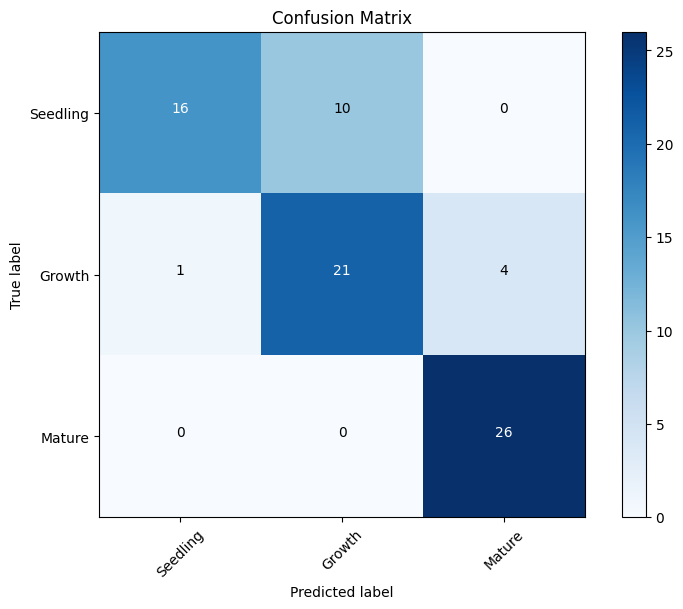

In [5]:
# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Seedling', 'Growth', 'Mature'] 
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [6]:
import matplotlib.patches as patches
from torchvision.datasets import ImageFolder
SAVE_PATH = './predicted_result'

PROJECT_PATH='./'
DATA_TEST = os.path.join(PROJECT_PATH, "Lettuce_Growth_Stages_Database/test_filter")
test_dataset = ImageFolder(root=DATA_TEST, transform=None)

for i, (image, label) in enumerate(test_dataset):
    image = image.resize((100, 100))
    predicted_label = predicted_labels[i]
    
    fig, ax = plt.subplots(figsize=(1, 1)) 
    ax.imshow(image)
    
    if predicted_label == 0:
        rect_color = 'blue'
        predicted_text = 'Seedling'
    elif predicted_label == 1:
        rect_color = 'orange'
        predicted_text = 'Growth'
    else:
        rect_color = 'red'
        predicted_text = 'Mature'
    
    rect = patches.Rectangle((5, 5), 90, 90, linewidth=1, edgecolor=rect_color, facecolor='none')
    ax.add_patch(rect)
    
    ax.axis('off')
    # plt.text(0, -5, f'Predicted Label: {predicted_label}, True: {label}', color=rect_color, fontsize=5, ha='left')
    plt.text(0, -5, f'Predicted: {predicted_text}', color=rect_color, fontsize=6, ha='left')

    save_filename = os.path.join(SAVE_PATH, f"SVMpredicted_image_{i}.png")
    fig.savefig(save_filename, dpi=100) 
    plt.close()  
print('Saved predicted result into predicted_result file!')

Saved predicted result into predicted_result file!
